In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import pandas as pd
import os
import emcee
import corner
from getdist import plots, gaussian_mixtures, MCSamples

In [12]:
os.listdir()
os.listdir('Pantheon_SNeIa_dataset/')

['lcparam_DS17f.txt']

In [13]:
#binned Pantheon SNe Ia data
full_data = pd.read_csv('Pantheon_SNeIa_dataset/lcparam_DS17f.txt',sep=' ')

redshift = full_data['zcmb']
appmag = full_data['mb']
appmag_unc = full_data['dmb']

#absolute magnitude for Type 1a SNe
absmag = -19.25

#distance modulus = m - M
distmod = appmag - absmag
distmod.shape
distmod_unc = appmag_unc

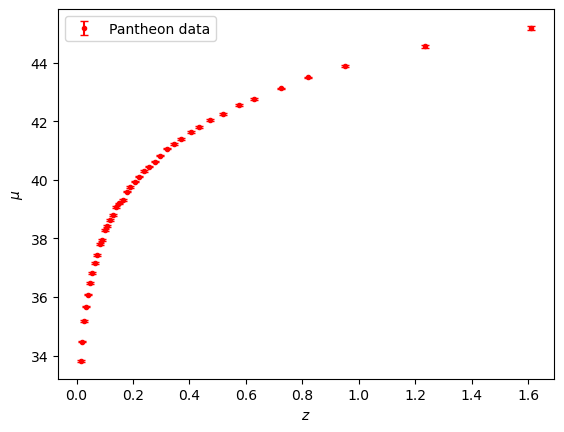

In [14]:
plt.figure()
plt.errorbar(redshift, distmod, yerr=distmod_unc, capsize=3, fmt='r.', label='Pantheon data')
plt.xlabel('$z$')
plt.ylabel('$\mu$')
plt.legend()
plt.show()

In [15]:
H0 = 70000 #Hubble param today in m/s/Mpc (in km/s/Mpc its 70)
ls = 299792458 #speed of light in m/s
Omrad = 5e-5

def integrand(z,Omm0,Oml0):
    res = 1./np.sqrt(Omrad*(1+z)**4 + Omm0*(1+z)**3 + Oml0)
    return res

def dL(z,Omm0,Oml0):
    #luminosity distance in Mpc
    integr = integrate.quad(integrand, 0, z, args=(Omm0,Oml0))
    return (1+z)*ls*integr[0]/H0

def dist_mod(lum_dist):
    res = 5.*np.log10(lum_dist) + 25.
    return res

def dLvect(z,Omm0,Oml0):
    #luminosity distance in Mpc
    length = len(z)
    res = []
    for i in range(length):
        integr = integrate.quad(integrand, 0, z[i], args=(Omm0,Oml0))
        res.append((1+z[i])*ls*integr[0]/H0)
    return res

In [16]:
# Define the log_likelihood function
def log_likelihood(params):
    Omm0, Oml0 = params
    theoretical_dm = dist_mod(dLvect(redshift, Omm0, Oml0))
    return -0.5*np.sum(((distmod.values - theoretical_dm)/distmod_unc.values)**2 + np.log(2*np.pi*distmod_unc**2))

In [17]:
# Uniform log_prior
def log_prior(params):
    Omm0, Oml0 = params
    if 0.0 <= Omm0 <= 1.0 and 0.0 <= Oml0 <= 1.0:
        return -np.log(1*1)
    return -np.inf

In [18]:
#Product, resp. sum in logarithm form of likelihood and prior
def log_sum(params):
    # Compute the log-prior
    lp = log_prior(params)
    if lp == -np.inf:
        # If the prior is zero (i.e. log is -infinity), return negative infinity
        return -np.inf
    
    # Compute the log-likelihood
    ll = log_likelihood(params)
    
    # Compute the log-posterior as the sum of the log-prior and log-likelihood
    return lp + ll

In [19]:
# Set the number of dimensions (i.e. the number of parameters)
ndim = 2

# Set the number of walkers
nwalkers = 5

# Define the range of values for each parameter
theta_min = [0, 0]
theta_max = [1, 1]

# Generate random starting positions for the walkers within the defined range
p0 = np.zeros((nwalkers, ndim))
for i in range(ndim):
    p0[:, i] = np.random.uniform(theta_min[i], theta_max[i], size=nwalkers)

# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_sum, args=())

In [20]:
# Run the sampler for a specified number of iterations
n_iterations = 1000
sampler.run_mcmc(p0, n_iterations, progress=True)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.05it/s]


State([[0.30519103 0.79929358]
 [0.2943578  0.81547984]
 [0.33236213 0.75740402]
 [0.30580153 0.79800498]
 [0.31762648 0.77772714]], log_prob=[81.16657604 80.23055956 79.68939768 81.17226909 80.73469496], blobs=None, random_state=('MT19937', array([ 230841419,  593752440, 1045442604,  138143251, 2121960843,
       2183585084, 3743820034, 2021930553, 4019404938,  509299931,
       3706678392, 1931540715, 1277174020, 1231810995, 2410463215,
        770001977, 4160626813,  149522385, 1319605272, 1684936016,
       1708729601, 2091371037, 2289104276, 1363560489, 3795702783,
       2974361292, 3854795864, 4078444888, 3521131437, 1758985241,
       3288348640, 4251784922,  957532941, 1895173129, 1911213923,
       2496066059,  977424076, 3219743429, 3608318688, 3416459396,
       4229030869, 4027191376, 1763265562, 3287991891,  627396199,
       2080868685, 2733409122, 2132247710, 2147748168, 1686110375,
       1242729189, 3013641077,  722888765, 4268402155, 3049556615,
       3036495820, 39

In [21]:
# Get the chain of samples produced by the sampler
samples = sampler.chain[:, :, :]
print(sampler.chain[:,:,:].shape)

# Discard the first few samples as burn-in
burnin = 100
final_samples = samples[:,burnin:, :]
print(final_samples.shape)

(5, 1000, 2)
(5, 900, 2)


(4500, 2)


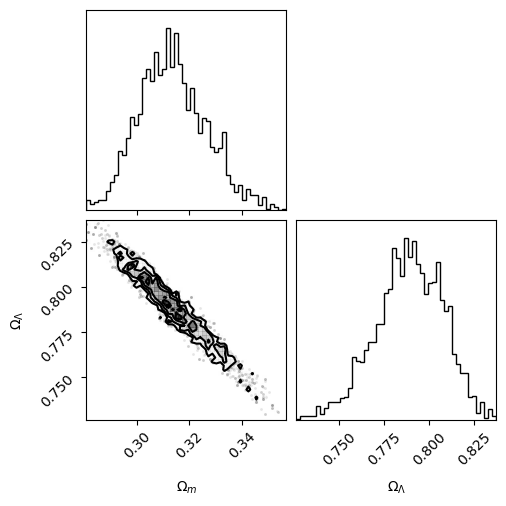

In [22]:
# Flatten the chain of samples
flat_samples = final_samples.reshape(-1, ndim)
print(flat_samples.shape)

# Plot the corner plot using the flattened samples
figure = corner.corner(flat_samples,bins=50, labels=['$\Omega_m$', '$\Omega_\Lambda$'])

# Show the plot
plt.show()

Removed no burn in


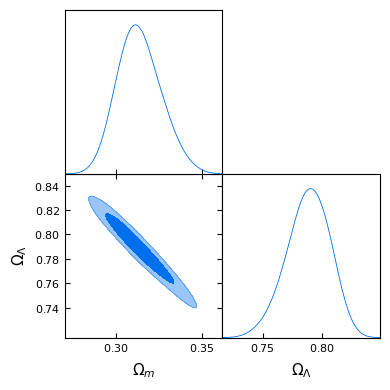

In [29]:
names = ['Omega_m', 'Omega_L']
labels =  ['\Omega_m', '\Omega_\Lambda']
samples_new = MCSamples(samples=np.array(flat_samples),names=names,labels=labels)
g = plots.get_subplot_plotter()
g.triangle_plot(samples_new, filled=True)
g.export('posterior.pdf')

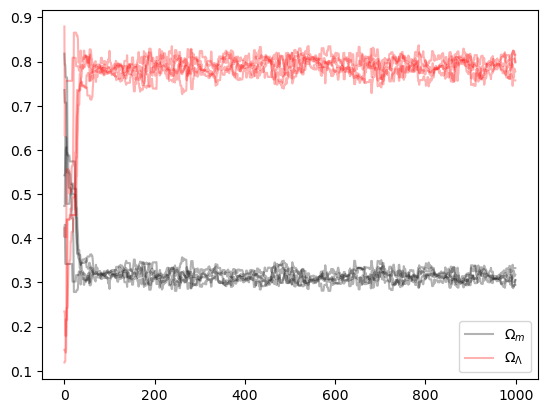

In [24]:
plt.figure()
plt.plot(samples[0,:,0].T, '-', color='k', alpha=0.3,label='$\Omega_m$')
plt.plot(samples[1:,:,0].T, '-', color='k', alpha=0.3)
plt.plot(samples[0,:,1].T, '-', color='r', alpha=0.3,label='$\Omega_\Lambda$')
plt.plot(samples[1:,:,1].T, '-', color='r', alpha=0.3)
plt.legend()
plt.show()

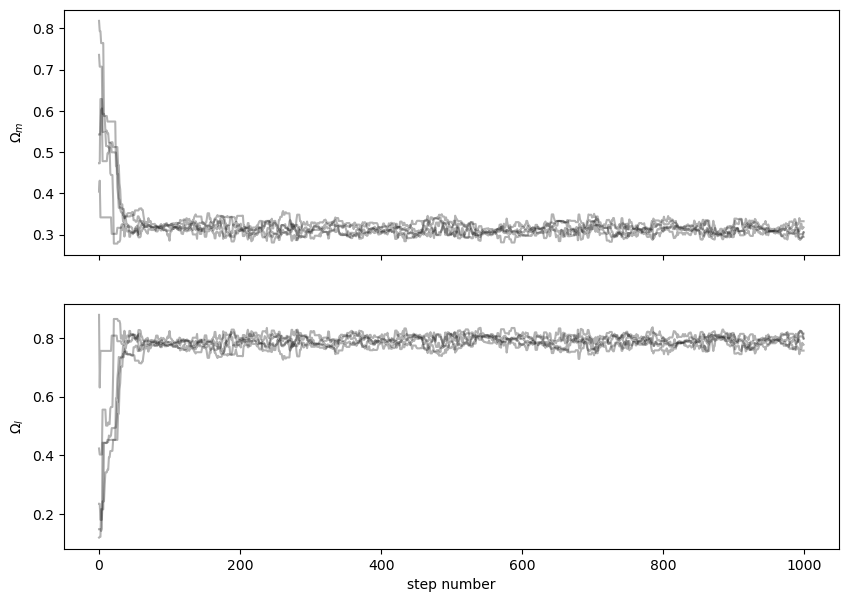

In [25]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$\Omega_m$", "$\Omega_l$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.chain[:,:,i].T, "k-", alpha=0.3)
    #ax.set_xlim(0, 10000)
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("step number");

In [26]:
#mean and std dev of Om_m
m1 = np.mean(flat_samples[:,0])
std1 = np.std(flat_samples[:,0])
print('Mean of Om_m = ',m1)
print('Std dev of Om_m = ',std1)

#mean and std dev of Om_l
m2 = np.mean(flat_samples[:,1])
std2 = np.std(flat_samples[:,1])
print('Mean of Om_l = ',m2)
print('Std dev of Om_l = ',std2)

Mean of Om_m =  0.31367413481675954
Std dev of Om_m =  0.012760048039989778
Mean of Om_l =  0.7887404777245474
Std dev of Om_l =  0.018506571604092643


C:\Users\armin\AppData\Local\Temp\ipykernel_14744\343564472.py:15: RuntimeWarning: divide by zero encountered in log10
  res = 5.*np.log10(lum_dist) + 25.


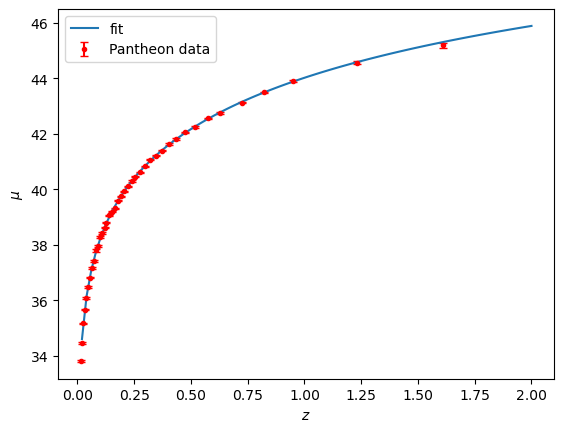

In [27]:
x = np.linspace(0,2,100)
y = dist_mod(dLvect(x,m1,m2))

plt.figure()
plt.errorbar(redshift, distmod, yerr=distmod_unc, capsize=3, fmt='r.', label='Pantheon data')
plt.plot(x,y,label='fit')
plt.plot
plt.xlabel('$z$')
plt.ylabel('$\mu$')
plt.legend()
plt.show()

In [28]:
BIC = ndim*np.log(np.size(redshift)) + 2*log_likelihood([m1,m2])
print(BIC)

170.1708524416983


In [ ]:
chidof = (-0.5*np.sum(((distmod.values - theoretical_dm)/distmod_unc.values)**2 + np.log(2*np.pi*distmod_unc**2)))/(np.size(redshift))